Neuron Synapse Competition

## Load in and Wrangle Training Data

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Basic info on these dataframes

In [208]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

See the documentation for additional information on these features.  The main dataframe contains features for each potential synapse (each row).  The outcome to predict is 'connected'.  Note that many of the raw features in this dataframe will not be directly useful for prediction (e.g. x,y,z coordiantes, pre- and post-synapse neuron ID and etc.).  You will need to creatively engineer new features that will be more useful for prediction.

The additional information on feature weights and morphological embeddings are given for each separate neuron (the neuron ID is matched with that in the main dataframe).  These will need to be merged with the other data to create training and test sets. 

#### Merge Data

Before merging, we concatenate the feature weights and morphological embeddings into np.array's to decrease memory usage.

In [209]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [210]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [211]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

## Basic Exploratory Analysis

In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Unbalanced Data

The outcomes, the adps that form a connection or synapse ('connected'==True) and the adps that do not synapse ('connected'==False), are unbalanced:

In [213]:
print("Number Connected (Synapses):",data['connected'].sum())

print("\nNumber Not Connected:",(~data['connected']).sum())

Number Connected (Synapses): 1366

Number Not Connected: 184466


The number of presynaptic neurons and postsynaptic neurons are also unbalanced:

In [214]:
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")

All the adps are from 77 pre- neurons and 2663 post- neurons.


### Exploration: Synaptic Proximity Distance 

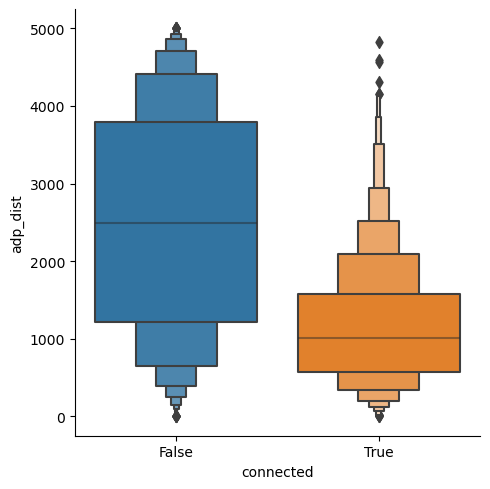

In [215]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen')


In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

### Imputing the pre-morph embeddings row

In [217]:
from sklearn.impute import SimpleImputer
import ast  # Module to safely evaluate literal strings as Python expressions

# Assuming 'data' is your DataFrame
column_to_impute = 'pre_morph_embeddings'

data[column_to_impute].fillna(0, inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [218]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# List of categorical columns
categorical_columns = ['compartment', 'pre_brain_area','post_brain_area']

# Apply label encoding to each categorical column
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Display the updated DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

### Calculating the Eulidean distances between the axonal and dendritic coordinates

In [219]:
# Calculating the Eulidean distances between the axonal and dendritic coordinates



# Calculate Euclidean distances and create a new column 'euclidean_distance'
data['euclidean_distance'] = np.sqrt(
    (data['axonal_coor_x'] - data['dendritic_coor_x'])**2 +
    (data['axonal_coor_y'] - data['dendritic_coor_y'])**2 +
    (data['axonal_coor_z'] - data['dendritic_coor_z'])**2
)

# The 'euclidean_distance' column now contains the Euclidean distances

# Calculate Euclidean distances between axonal and dendritic coordinates for both pre and post neurons
data['axonal_distance_pre'] = np.sqrt((data['axonal_coor_x'] - data['dendritic_coor_x'])**2 + (data['axonal_coor_y'] - data['dendritic_coor_y'])**2)
data['axonal_distance_post'] = np.sqrt((data['axonal_coor_x'] - data['dendritic_coor_x'])**2 + (data['axonal_coor_y'] - data['dendritic_coor_y'])**2)

data['dendritic_distance_pre'] = np.sqrt((data['dendritic_coor_x'] - data['axonal_coor_x'])**2 + (data['dendritic_coor_y'] - data['axonal_coor_y'])**2)
data['dendritic_distance_post'] = np.sqrt((data['dendritic_coor_x'] - data['axonal_coor_x'])**2 + (data['dendritic_coor_y'] - data['axonal_coor_y'])**2)

# Combine these distances with Euclidean distances between readout locations
data['euclidean_distance_pre'] = np.sqrt((data['pre_rf_x'] - data['post_rf_x'])**2 + (data['pre_rf_y'] - data['post_rf_y'])**2)
data['euclidean_distance_post'] = np.sqrt((data['pre_rf_x'] - data['post_rf_x'])**2 + (data['pre_rf_y'] - data['post_rf_y'])**2)

# Dataset contains both structural (axonal and dendritic distances) and spatial (Euclidean distances) features.


# Calculate the relative positions of post-synaptic neurons with respect to pre-synaptic neurons
data['relative_position_x'] = data['post_rf_x'] - data['pre_rf_x']
data['relative_position_y'] = data['post_rf_y'] - data['pre_rf_y']

# dataset contains "relative_position_x" and "relative_position_y" features

# Create binary directional features
data['is_left'] = (data['relative_position_x'] < 0).astype(int)
data['is_right'] = (data['relative_position_x'] > 0).astype(int)
data['is_above'] = (data['relative_position_y'] < 0).astype(int)
data['is_below'] = (data['relative_position_y'] > 0).astype(int)

# Dataset contains binary directional features

# Create interaction terms between rf_x and rf_y for pre-synaptic neurons
data['pre_rf_x_rf_y_interaction'] = data['pre_rf_x'] * data['pre_rf_y']

# Create interaction terms between rf_x and rf_y for post-synaptic neurons
data['post_rf_x_rf_y_interaction'] = data['post_rf_x'] * data['post_rf_y']

# The dataset now contains interaction terms that capture relationships in visual space

#### Engineering the Morphological Embeddings

In [220]:
scaler = StandardScaler()
data['pre_morph_embeddings'] = data['pre_morph_embeddings'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)))
data['post_morph_embeddings'] = data['post_morph_embeddings'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)))



In [221]:
def flatten_arrays(arrays):
    return [item for sublist in arrays for item in sublist]

data['pre_morph_embeddings'] = data['pre_morph_embeddings'].apply(flatten_arrays)
data['post_morph_embeddings'] = data['post_morph_embeddings'].apply(flatten_arrays)


In [222]:
data['pre_morph_embeddings']

0         [0.6232024290914828, 0.4064975073674162, -0.03...
1         [0.6232024290914828, 0.4064975073674162, -0.03...
2         [0.6232024290914828, 0.4064975073674162, -0.03...
3         [0.6232024290914828, 0.4064975073674162, -0.03...
4         [0.6232024290914828, 0.4064975073674162, -0.03...
                                ...                        
185827    [-0.029840314426819902, 0.7348434172042577, -0...
185828    [-0.029840314426819902, 0.7348434172042577, -0...
185829    [-0.029840314426819902, 0.7348434172042577, -0...
185830    [-0.029840314426819902, 0.7348434172042577, -0...
185831    [-0.029840314426819902, 0.7348434172042577, -0...
Name: pre_morph_embeddings, Length: 185832, dtype: object

In [223]:
from sklearn.decomposition import PCA
import numpy as np

# Ensure all arrays in 'pre_morph_embeddings' and 'post_morph_embeddings' have the same size
data['pre_morph_embeddings'] = data['pre_morph_embeddings'].apply(lambda x: np.array(x) if len(x) == 32 else np.array([0.0] * 32))
data['post_morph_embeddings'] = data['post_morph_embeddings'].apply(lambda x: np.array(x) if len(x) == 32 else np.array([0.0] * 32))

# Apply PCA
pca = PCA(n_components=2)
data['pre_morph_embeddings'] = list(pca.fit_transform(np.vstack(data['pre_morph_embeddings'])))
data['post_morph_embeddings'] = list(pca.fit_transform(np.vstack(data['post_morph_embeddings'])))


In [224]:
data['post_morph_embeddings']

0         [4.325374501135259, -1.4753532756345717]
1         [4.325374501135145, -1.4753532756347483]
2         [4.325374501135145, -1.4753532756346757]
3         [4.325374501135145, -1.4753532756346752]
4         [4.325374501135145, -1.4753532756346752]
                            ...                   
185827      [4.44458705311881, -1.215484364168003]
185828      [4.44458705311881, -1.215484364168003]
185829      [4.44458705311881, -1.215484364168003]
185830      [4.44458705311881, -1.215484364168003]
185831      [4.44458705311881, -1.215484364168003]
Name: post_morph_embeddings, Length: 185832, dtype: object

### Engineering the Feature Weights column

In [225]:
scaler = StandardScaler()
data['pre_feature_weights'] = data['pre_feature_weights'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)))
data['post_feature_weights'] = data['post_feature_weights'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)))


def flatten_arrays(arrays):
    return [item for sublist in arrays for item in sublist]

data['pre_feature_weights'] = data['pre_feature_weights'].apply(flatten_arrays)
data['post_feature_weights'] = data['post_feature_weights'].apply(flatten_arrays)


# Apply PCApost_feature_weights
pca = PCA(n_components=2)
data['pre_feature_weights'] = list(pca.fit_transform(np.vstack(data['pre_feature_weights'])))
data['post_feature_weights'] = list(pca.fit_transform(np.vstack(data['post_feature_weights'])))



# # Extract feature weight columns
# feature_weight_columns = ['pre_feature_weights', 'post_feature_weights']

# # Standardize the data
# scaler = StandardScaler()
# data[feature_weight_columns] = scaler.fit_transform(data[feature_weight_columns])

# # Create a PCA object
# pca = PCA(n_components=2)
# data_pca = pca.fit_transform(data[feature_weight_columns])


In [226]:
data['pre_feature_weights']

0         [-6.496702112733109, 3.1630279916105373]
1         [-6.496702112738727, 3.1630279916103157]
2         [-6.4967021127334625, 3.163027991586551]
3         [-6.496702112736233, 3.1630279916188204]
4         [-6.496702112736433, 3.1630279916150754]
                            ...                   
185827    [8.316861599333654, 0.25540881170080737]
185828    [8.316861599333654, 0.25540881170080737]
185829    [8.316861599333654, 0.25540881170080737]
185830    [8.316861599333654, 0.25540881170080737]
185831    [8.316861599333654, 0.25540881170080737]
Name: pre_feature_weights, Length: 185832, dtype: object

In [227]:
from scipy.stats import skew, kurtosis

data['pre_feature_weights_sum'] = data['pre_feature_weights'].apply(lambda x: sum(x))
data['post_feature_weights_sum'] = data['post_feature_weights'].apply(lambda x: sum(x))
data['feature_weights_difference'] = abs(data['pre_feature_weights_sum'] - data['post_feature_weights_sum'])

data['pre_feature_weights_variance'] = data['pre_feature_weights'].apply(lambda x: np.var(x))
data['post_feature_weights_variance'] = data['post_feature_weights'].apply(lambda x: np.var(x))


data['pre_feature_weights_skewness'] = data['pre_feature_weights'].apply(lambda x: skew(x))
data['post_feature_weights_skewness'] = data['post_feature_weights'].apply(lambda x: skew(x))
data['pre_feature_weights_kurtosis'] = data['pre_feature_weights'].apply(lambda x: kurtosis(x))
data['post_feature_weights_kurtosis'] = data['post_feature_weights'].apply(lambda x: kurtosis(x))

In [229]:
from scipy.stats import skew, kurtosis
import numpy as np


# Sum the morphological embeddings for pre and post neurons
data['pre_morph_embeddings_sum'] = data['pre_morph_embeddings'].apply(lambda x: np.sum(x, axis=0))
data['post_morph_embeddings_sum'] = data['post_morph_embeddings'].apply(lambda x: np.sum(x, axis=0))

# Calculate the Euclidean distance between summed morphological embeddings
data['morph_embeddings_distance'] = data.apply(lambda row: np.linalg.norm(row['pre_morph_embeddings_sum'] - row['post_morph_embeddings_sum']), axis=1)

# Calculate the variance of morphological embeddings
data['pre_morph_embeddings_variance'] = data['pre_morph_embeddings'].apply(lambda x: np.var(x, axis=0))
data['post_morph_embeddings_variance'] = data['post_morph_embeddings'].apply(lambda x: np.var(x, axis=0))

# Calculate the skewness and kurtosis of morphological embeddings
data['pre_morph_embeddings_skewness'] = data['pre_morph_embeddings'].apply(lambda x: skew(x, axis=0))
data['post_morph_embeddings_skewness'] = data['post_morph_embeddings'].apply(lambda x: skew(x, axis=0))
data['pre_morph_embeddings_kurtosis'] = data['pre_morph_embeddings'].apply(lambda x: kurtosis(x, axis=0))
data['post_morph_embeddings_kurtosis'] = data['post_morph_embeddings'].apply(lambda x: kurtosis(x, axis=0))


In [230]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 67 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

### Perform PCA on the whole dataset

In [80]:
# data = data.select_dtypes(exclude=['object'])

In [231]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 67 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 67 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

## Example: Basic Feature Engineering

### Exploration: Neurons that form a synpase tend to have similar functional neural responses

Neurons in the visual cortex each respond differently to visual stimuli.  This is often captured by a neuron's tuning function, or the visual features that drive a neuron to fire.  The feature weight vectors ('feature_weights') are a kind of summary of each neuron's tuning function.  Neuroscience suggests that neurons with similar tuning are slightly more likely to be connected.  To assess this, we would need to engineer a new feature that capture the tuning similarity of the pre- and post- synaptic neurons for each ADP.  (See the documentation for more details).  

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [233]:

#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# def row_morph_embeddings(row):
#     pre = row["pre_morph_embeddings"]
#     post = row["post_morph_embeddings"]
#     return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))


 

# def row_oracle(row):
#     pre = row["pre_oracle"]
#     post = row["post_oracle"]
#     return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# def row_rf_x(row):
#     pre = np.array(row["pre_rf_x"])
#     post = np.array(row["post_rf_x"])
#     return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# def row_rf_y(row):
#     pre = np.array(row["pre_rf_y"])
#     post = np.array(row["post_rf_y"])
#     return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

    

    

In [234]:
column_name = "post_feature_weights"

print(data[column_name])



0          [0.7874549293809473, -0.5553607679224069]
1          [0.7874549293807959, -0.5553607679228016]
2          [0.7874549293807841, -0.5553607679225818]
3          [0.7874549293807893, -0.5553607679226082]
4           [0.7874549293807895, -0.555360767922601]
                             ...                    
185827    [-2.6152764441033796, -3.6873775139237317]
185828    [-2.6152764441033796, -3.6873775139237317]
185829    [-2.6152764441033796, -3.6873775139237317]
185830    [-2.6152764441033796, -3.6873775139237317]
185831    [-2.6152764441033796, -3.6873775139237317]
Name: post_feature_weights, Length: 185832, dtype: object


In [235]:
column_name = "post_morph_embeddings"
row_index = 4  

# Access the column first and then the row
value = data[column_name][row_index]

# Print the value
print(value)


[ 4.3253745  -1.47535328]


In [236]:
# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
# data["morph_embeddings"] = data.apply(row_morph_embeddings, axis=1)

# data["rf_x"] = data.apply(row_rf_x, axis=1)
# data["rf_y"] = data.apply(row_rf_y, axis=1)
# data["oracle"] = data.apply(row_oracle, axis=1)

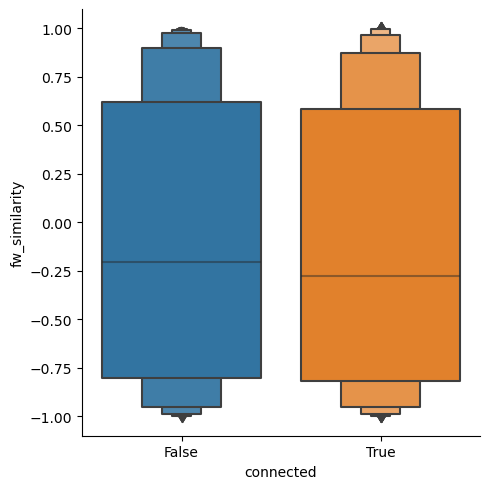

In [237]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')
# sns.catplot(data=data, x='connected', y='post_morph_embeddings', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [238]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

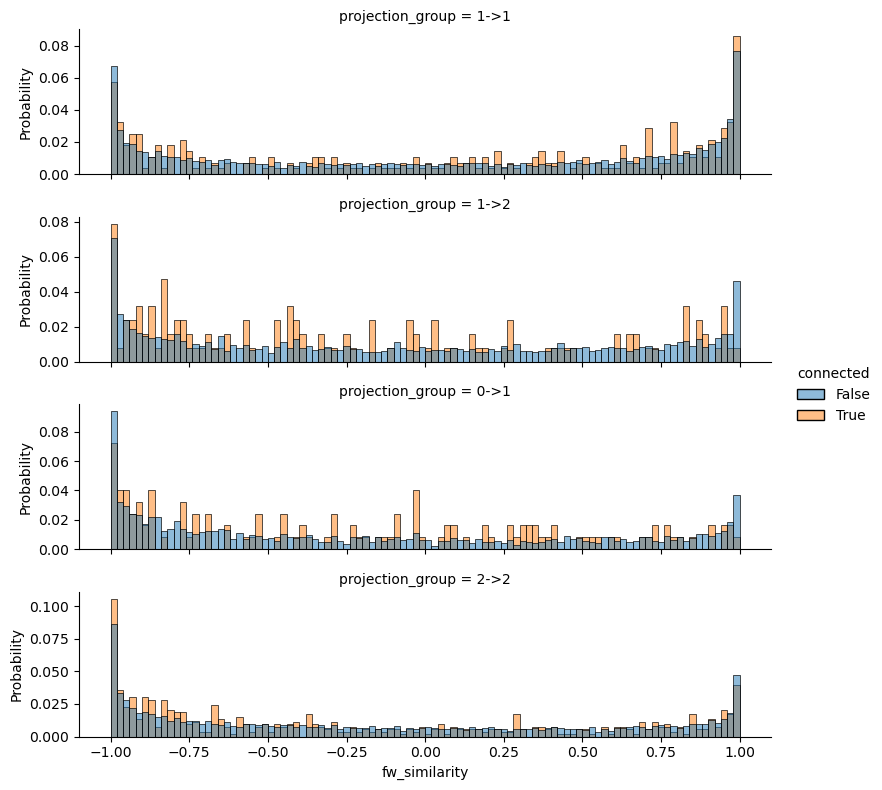

In [239]:
# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'), 
    x='fw_similarity', 
    hue='connected', 
    row='projection_group',
    common_norm=False, 
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False}
)

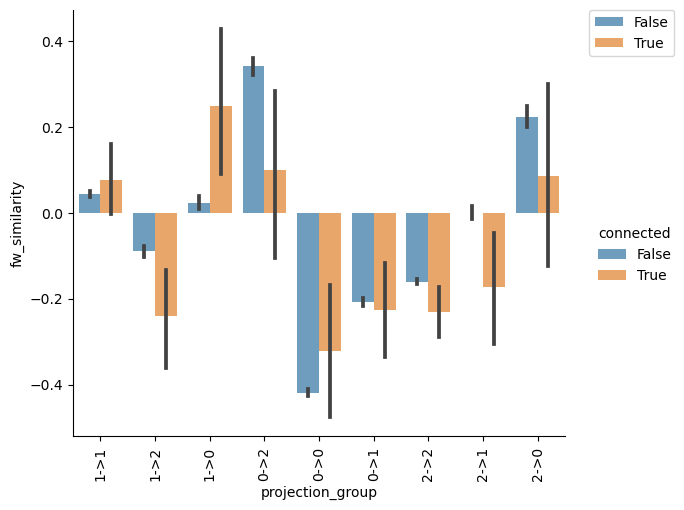

In [240]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

We have shown some simple examples of how to engineer new features and also shown that these are related to neuron connectivity.  You will likley need to explore and engineer many other possible features in this competition.  

## Example: Logistic Regression

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 69 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [242]:
print(data['pre_morph_embeddings']) 



0         [3.6130228898090047, -1.6114389622344705]
1          [3.613022889808816, -1.6114389622401992]
2         [3.6130228898088137, -1.6114389622403005]
3         [3.6130228898088137, -1.6114389622403007]
4         [3.6130228898088137, -1.6114389622403005]
                            ...                    
185827    [2.3873571371336655, -1.1669078599815337]
185828    [2.3873571371336655, -1.1669078599815337]
185829    [2.3873571371336655, -1.1669078599815337]
185830    [2.3873571371336655, -1.1669078599815337]
185831    [2.3873571371336655, -1.1669078599815337]
Name: pre_morph_embeddings, Length: 185832, dtype: object


In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 69 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

### Engineering the Morph Embeddings column

In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 69 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

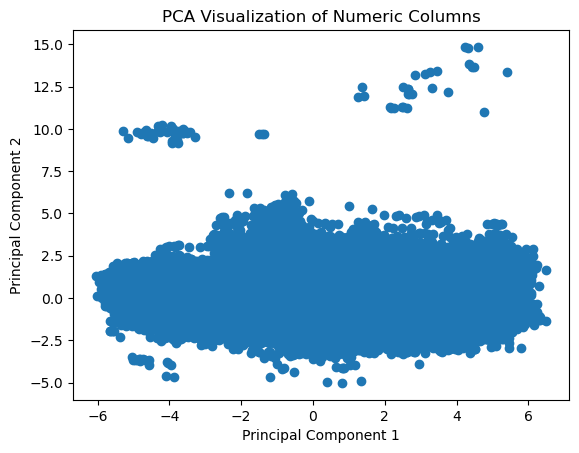

In [245]:
# Apply PCA to data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Exclude non-numeric and non-categorical columns from the PCA
exclude_cols = ['ID', 
                'pre_feature_weights', 
                'post_feature_weights', 
                'pre_morph_embeddings', 
                'post_morph_embeddings', 
                'projection_group', 
                'connected',
                'is_left',
                'is_right',
                'is_above',
                'is_below'
               ]

# Select only numeric columns for PCA
numeric_columns = [col for col in data.columns if col not in exclude_cols]

# Standardize the data (if needed)
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Create a PCA object (you can specify the number of components)
pca = PCA(n_components=15)

# Fit and transform the data
pca_result = pca.fit_transform(data[numeric_columns])

# # Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15'])

# Visualize the PCA results
plt.scatter(pca_df['1'], pca_df['15'])
plt.title('PCA Visualization of Numeric Columns')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 69 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  float64
 2   axonal_coor_y                   185832 non-null  float64
 3   axonal_coor_z                   185832 non-null  float64
 4   dendritic_coor_x                185832 non-null  float64
 5   dendritic_coor_y                185832 non-null  float64
 6   dendritic_coor_z                185832 non-null  float64
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

Now that we have shown some features are associated with neuron connectivity, we fit a simple calssification model: Logistic Regression.

In [251]:
# logistic regression model (connected ~ fw_similarity + adp)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.random_seed=0
# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

# # create pipeline - Random Forest
# pipe = Pipeline(
#     [("scaler", StandardScaler()), ("model", RandomForestClassifier(n_estimators=100, 
#                                                                     max_depth=None, 
#                                                                     min_samples_leaf=1, 
#                                                                     class_weight='balanced',
#                                                                     bootstrap=True,
#                                                                     random_state=42))]
# )

# # create pipeline
# pipe = Pipeline(
#     [("scaler", StandardScaler()), ("model", LogisticRegression(random_state=42,
#                                                                C= 10,
#                                                                penalty ="l1",
#                                                                class_weight="balanced",
#                                                                solver="liblinear"))]
# )

# # create pipeline
# pipe = Pipeline(
#     [("scaler", StandardScaler()), ("model", SVC(kernel= "linear", probability=True, class_weight='balanced', random_state=2))]
# )

# create pipeline
pipe = Pipeline(
    [("scaler", StandardScaler()), ("model", LinearDiscriminantAnalysis(solver="eigen", shrinkage=0.00001))]
)
# creating train data
X_train = train_data[["fw_similarity", 
                      "adp_dist",  
                      "post_skeletal_distance_to_soma",
                      "pre_skeletal_distance_to_soma",
                      "pre_oracle",
                      "post_oracle",
                      "pre_test_score",
                      "post_test_score",
                      "compartment",
                      "pre_brain_area",
                      "post_brain_area",
                      "euclidean_distance",
                      "axonal_distance_pre",
                      "axonal_distance_post",
                      "dendritic_distance_pre",
                      "dendritic_distance_post",
                      "euclidean_distance_pre",
                      "euclidean_distance_post",
                      "relative_position_x",
                      "relative_position_y",
                      "is_left",
                      "is_right",
                      "is_above",
                      "is_below",
                      "pre_rf_x_rf_y_interaction",
                      "post_rf_x_rf_y_interaction",
                      "feature_weights_difference",
                      "morph_embeddings_distance"
                      
                      
                      
                      
                      
                      
                                    
                      
                      
                      
                      
                     ]]

y_train = train_data["connected"]

X_test = test_data[[  "fw_similarity", 
                      "adp_dist",  
                      "post_skeletal_distance_to_soma",
                      "pre_skeletal_distance_to_soma",
                      "pre_oracle",
                      "post_oracle",
                      "pre_test_score",
                      "post_test_score",
                      "compartment",
                      "pre_brain_area",
                      "post_brain_area",
                      "euclidean_distance",
                      "axonal_distance_pre",
                      "axonal_distance_post",
                      "dendritic_distance_pre",
                      "dendritic_distance_post",
                      "euclidean_distance_pre",
                      "euclidean_distance_post",
                      "relative_position_x",
                      "relative_position_y",
                      "is_left",
                      "is_right",
                      "is_above",
                      "is_below",
                      "pre_rf_x_rf_y_interaction",
                      "post_rf_x_rf_y_interaction",
                      "feature_weights_difference",
                      "morph_embeddings_distance"
                   
                    
                      
                   
                   
                   ]]

y_test = test_data['connected']
# fit model
pipe.fit(X_train, y_train)

# predict on test data
y_preds = pipe.predict_proba(X_test)[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(y_test, y_preds > .5)}")


accuracy: 0.9927085855732236


In [99]:
confusion_matrix(y_test, y_preds > .5)

array([[36896,     0],
       [  271,     0]], dtype=int64)

The model always predicts not connected!  We need a new evaluation metric.

### Balanced Accuracy Metric

Sensitivity = True Positive Rate = True Positive / (True Positive + False Negative)
Specificity = True Negative Rate = True Negative / (True Negative + False Positive)

Balanced Accuracy = (Sensitivity + Specificity)/2

In [100]:
print(
    f"balanced accuracy: {balanced_accuracy_score(y_test, y_preds > .5)}"
)

balanced accuracy: 0.5


In [101]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  float64
 2   axonal_coor_y                   185832 non-null  float64
 3   axonal_coor_z                   185832 non-null  float64
 4   dendritic_coor_x                185832 non-null  float64
 5   dendritic_coor_y                185832 non-null  float64
 6   dendritic_coor_z                185832 non-null  float64
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

## Data Augmentation for Unbalanced Classification

As our simple model always predicts not connected, we need to use some technique that balances the two classes.  While there are many strategies one can employ, we demostrate a simple random over sampling strategy that uses the bootstrap to augment the data for the minority ('connected') class.  

In [252]:

from imblearn.over_sampling import RandomOverSampler


# oversample connected neuron pairs
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    X_train, y_train
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
y_preds = pipe.predict_proba(X_test)[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(y_test, y_preds > .5)}")

# confusion matrix
print(confusion_matrix(y_test, y_preds > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(y_test, y_preds > .5)}"
)

accuracy: 0.6610703043022036
[[24344 12552]
 [   45   226]]
balanced accuracy: 0.7468744299325041


### Hyperparameter tuning

In [103]:
# #Logistic Regression tuning
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
# from scipy.stats import uniform, randint

# # # Create a hyperparameter grid for RandomForestClassifier
# # param_dist = {"n_estimators": np.arange(100, 1000, 10),
# #             'max_depth': [None, 10, 20, 30, 40],
# #             'min_samples_split': [2, 5, 10],
# #             'min_samples_leaf': [1, 2, 4],
# #             'max_features': ['sqrt', 'log2', 0.2, 0.5],
# #             'class_weight': ['balanced'],
# #             'bootstrap': [True],
# #             'criterion': ['gini', 'entropy']
# #           }

# param_dist = {
#    "C": np.linspace(0.001, 4,1000),
#     'penalty': ['l1','l2'],
#     'class_weight': ['balanced'],
#     'solver': ['liblinear']
    
# }
# #setup random seed
# np.random.seed(42)



# # Create a StratifiedKFold object for stratified K-fold cross-validation
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # #setup random hyperparameter search for LogisticRegression
# # rs_rf = RandomizedSearchCV(RandomForestClassifier(),
# #                                  param_distributions=param_dist,
# #                                  cv=stratified_kfold,
# #                                  n_iter=2,
# #                                  n_jobs=-1,
# #                                  verbose=True)

# #setup random hyperparameter search for LogisticRegression
# rs_lr = RandomizedSearchCV(LogisticRegression(),
#                                  param_distributions=param_dist,
#                                  cv=stratified_kfold,
#                                  n_iter=100,
                           
#                                  verbose=True)

# #Split data again
# # train_data, test_data = train_test_split(data, test_size=0.1, random_state=1)

# # Fit random hyperparameter search model for LogisticRegression()
# rs_rf.fit(X_resampled, y_resampled )

In [104]:
# # Find the best hyperparameters

# best_params = rs_rf.best_params_
# rs_rf.best_params_

In [105]:
# # Fit it with the best params
# best_model = RandomForestClassifier(**best_params)
# best_model.fit(X_resampled, y_resampled)

In [106]:

# # predict on test data
# y_preds = best_model.predict_proba(X_test)[:, 1]

In [107]:

# # compute accuracy
# print(f"accuracy: {accuracy_score(y_test, y_preds > .5)}")

# # confusion matrix
# print(confusion_matrix(y_test, y_preds > .5))

# # compute balanced accuracy
# print(
#     f"balanced accuracy: {balanced_accuracy_score(y_test, y_preds > .5)}"
# )

Simple data augmentation improves our balanced accuracy dramatically!

# Create Example Prediction File for Leaderboard Submission

### Load and Merge Leaderboard Data

In [108]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [109]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [110]:
lb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              42593 non-null  int64  
 1   axonal_coor_x                   42593 non-null  int64  
 2   axonal_coor_y                   42593 non-null  int64  
 3   axonal_coor_z                   42593 non-null  int64  
 4   dendritic_coor_x                42593 non-null  int64  
 5   dendritic_coor_y                42593 non-null  int64  
 6   dendritic_coor_z                42593 non-null  int64  
 7   adp_dist                        42593 non-null  float64
 8   post_skeletal_distance_to_soma  42593 non-null  float64
 9   pre_skeletal_distance_to_soma   42593 non-null  float64
 10  pre_oracle                      42593 non-null  float64
 11  pre_test_score                  42593 non-null  float64
 12  pre_rf_x                        

### Example Prediction: Simple Logistic Regression

Now we fit a our logistic regression model on the full training data and use it to make predictions on the leaderboard data. But first, we need to add in our new engineered feature on neural tuning similarity.  

#### Fill in the missing values


In [111]:

column_to_impute = 'pre_morph_embeddings'

lb_data[column_to_impute].fillna(0, inplace=True)

lb_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              42593 non-null  int64  
 1   axonal_coor_x                   42593 non-null  int64  
 2   axonal_coor_y                   42593 non-null  int64  
 3   axonal_coor_z                   42593 non-null  int64  
 4   dendritic_coor_x                42593 non-null  int64  
 5   dendritic_coor_y                42593 non-null  int64  
 6   dendritic_coor_z                42593 non-null  int64  
 7   adp_dist                        42593 non-null  float64
 8   post_skeletal_distance_to_soma  42593 non-null  float64
 9   pre_skeletal_distance_to_soma   42593 non-null  float64
 10  pre_oracle                      42593 non-null  float64
 11  pre_test_score                  42593 non-null  float64
 12  pre_rf_x                        

In [112]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# List of categorical columns
categorical_columns = ['compartment', 'pre_brain_area','post_brain_area']

# Apply label encoding to each categorical column
for column in categorical_columns:
    lb_data[column] = label_encoder.fit_transform(lb_data[column])

# Display the updated DataFrame
lb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              42593 non-null  int64  
 1   axonal_coor_x                   42593 non-null  int64  
 2   axonal_coor_y                   42593 non-null  int64  
 3   axonal_coor_z                   42593 non-null  int64  
 4   dendritic_coor_x                42593 non-null  int64  
 5   dendritic_coor_y                42593 non-null  int64  
 6   dendritic_coor_z                42593 non-null  int64  
 7   adp_dist                        42593 non-null  float64
 8   post_skeletal_distance_to_soma  42593 non-null  float64
 9   pre_skeletal_distance_to_soma   42593 non-null  float64
 10  pre_oracle                      42593 non-null  float64
 11  pre_test_score                  42593 non-null  float64
 12  pre_rf_x                        

### Adding engineered distances

In [113]:
# Calculating the Eulidean distances between the axonal and dendritic coordinates



# Calculate Euclidean distances and create a new column 'euclidean_distance'
lb_data['euclidean_distance'] = np.sqrt(
    (lb_data['axonal_coor_x'] - lb_data['dendritic_coor_x'])**2 +
    (lb_data['axonal_coor_y'] - lb_data['dendritic_coor_y'])**2 +
    (lb_data['axonal_coor_z'] - lb_data['dendritic_coor_z'])**2
)

# The 'euclidean_distance' column now contains the Euclidean distances


# Calculate Euclidean distances between axonal and dendritic coordinates for both pre and post neurons
lb_data['axonal_distance_pre'] = np.sqrt((lb_data['axonal_coor_x'] - lb_data['dendritic_coor_x'])**2 + (lb_data['axonal_coor_y'] - lb_data['dendritic_coor_y'])**2)
lb_data['axonal_distance_post'] = np.sqrt((lb_data['axonal_coor_x'] - lb_data['dendritic_coor_x'])**2 + (lb_data['axonal_coor_y'] - lb_data['dendritic_coor_y'])**2)

lb_data['dendritic_distance_pre'] = np.sqrt((lb_data['dendritic_coor_x'] - lb_data['axonal_coor_x'])**2 + (lb_data['dendritic_coor_y'] - lb_data['axonal_coor_y'])**2)
lb_data['dendritic_distance_post'] = np.sqrt((lb_data['dendritic_coor_x'] - lb_data['axonal_coor_x'])**2 + (lb_data['dendritic_coor_y'] - lb_data['axonal_coor_y'])**2)

# Combine these distances with Euclidean distances between readout locations
lb_data['euclidean_distance_pre'] = np.sqrt((lb_data['pre_rf_x'] - lb_data['post_rf_x'])**2 + (lb_data['pre_rf_y'] - lb_data['post_rf_y'])**2)
lb_data['euclidean_distance_post'] = np.sqrt((lb_data['pre_rf_x'] - lb_data['post_rf_x'])**2 + (lb_data['pre_rf_y'] - lb_data['post_rf_y'])**2)

# Dataset contains both structural (axonal and dendritic distances) and spatial (Euclidean distances) features.

# Create interaction terms between rf_x and rf_y for pre-synaptic neurons
lb_data['pre_rf_x_rf_y_interaction'] = lb_data['pre_rf_x'] * lb_data['pre_rf_y']

# Create interaction terms between rf_x and rf_y for post-synaptic neurons
lb_data['post_rf_x_rf_y_interaction'] = lb_data['post_rf_x'] * lb_data['post_rf_y']

# The dataset now contains interaction terms that capture relationships in visual space


# Calculate the relative positions of post-synaptic neurons with respect to pre-synaptic neurons
lb_data['relative_position_x'] = lb_data['post_rf_x'] - lb_data['pre_rf_x']
lb_data['relative_position_y'] = lb_data['post_rf_y'] - lb_data['pre_rf_y']

# dlb_dataataset contains "relative_position_x" and "relative_position_y" features

# Create binary directional features
lb_data['is_left'] = (lb_data['relative_position_x'] < 0).astype(int)
lb_data['is_right'] = (lb_data['relative_position_x'] > 0).astype(int)
lb_data['is_above'] = (lb_data['relative_position_y'] < 0).astype(int)
lb_data['is_below'] = (lb_data['relative_position_y'] > 0).astype(int)

# Dataset contains binary directional features



In [117]:
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)




lb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              42593 non-null  int64  
 1   axonal_coor_x                   42593 non-null  int64  
 2   axonal_coor_y                   42593 non-null  int64  
 3   axonal_coor_z                   42593 non-null  int64  
 4   dendritic_coor_x                42593 non-null  int64  
 5   dendritic_coor_y                42593 non-null  int64  
 6   dendritic_coor_z                42593 non-null  int64  
 7   adp_dist                        42593 non-null  float64
 8   post_skeletal_distance_to_soma  42593 non-null  float64
 9   pre_skeletal_distance_to_soma   42593 non-null  float64
 10  pre_oracle                      42593 non-null  float64
 11  pre_test_score                  42593 non-null  float64
 12  pre_rf_x                        

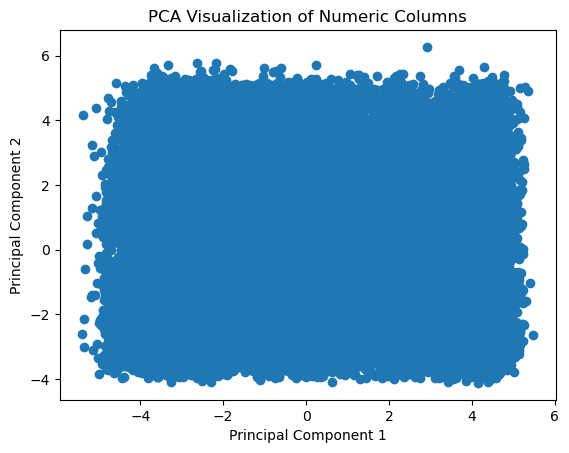

In [118]:
# Apply PCA to lb_data


# Exclude non-numeric and non-categorical columns from the PCA
exclude_cols = ['ID', 
                'pre_feature_weights',
                'post_feature_weights', 
                'pre_morph_embeddings', 
                'post_morph_embeddings',
                'is_left',
                'is_right',
                'is_above',
                'is_below'
               ]

# Select only numeric columns for PCA
numeric_columns = [col for col in lb_data.columns if col not in exclude_cols]

# Standardize the data (if needed)
scaler = StandardScaler()
lb_data[numeric_columns] = scaler.fit_transform(lb_data[numeric_columns])

# Create a PCA object (you can specify the number of components)
pca = PCA(n_components=15)

# Fit and transform the data
pca_result = pca.fit_transform(lb_data[numeric_columns])

# # Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15'])

# Visualize the PCA results
plt.scatter(pca_df['1'], pca_df['2'])
plt.title('PCA Visualization of Numeric Columns')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [119]:
# oversample connected neuron pairs for full training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    data[["fw_similarity", 
          "adp_dist",  
          "post_skeletal_distance_to_soma",
          "pre_skeletal_distance_to_soma",
          "pre_oracle",
          "post_oracle",
          "pre_test_score",
          "post_test_score",
          "pre_rf_x",
          "pre_rf_y",
          "post_rf_x",
          "post_rf_y",
          "compartment",
          "pre_brain_area",
          "post_brain_area",
          "euclidean_distance",
          "axonal_distance_pre",
          "axonal_distance_post",
          "dendritic_distance_pre",
          "dendritic_distance_post",
          "euclidean_distance_pre",
          "euclidean_distance_post",
          "relative_position_x",
          "relative_position_y",
          "is_left",
          "is_right",
          "is_above",
          "is_below",
          "pre_rf_x_rf_y_interaction",
          "post_rf_x_rf_y_interaction"
                      
         
         ]], 
    
    data["connected"]
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on leaderboard data
lb_data["pred"] = pipe.predict_proba(lb_data[["fw_similarity", 
                                              "adp_dist",  
                                              "post_skeletal_distance_to_soma",
                                              "pre_skeletal_distance_to_soma",
                                              "pre_oracle",
                                              "post_oracle",
                                              "pre_test_score",
                                              "post_test_score",
                                              "pre_rf_x",
                                              "pre_rf_y",
                                              "post_rf_x",
                                              "post_rf_y",
                                              "compartment",
                                              "pre_brain_area",
                                              "post_brain_area",
                                              "euclidean_distance",
                                              "axonal_distance_pre",
                                              "axonal_distance_post",
                                              "dendritic_distance_pre",
                                              "dendritic_distance_post",
                                              "euclidean_distance_pre",
                                              "euclidean_distance_post",
                                              "relative_position_x",
                                              "relative_position_y",
                                              "is_left",
                                              "is_right",
                                              "is_above",
                                              "is_below",
                                              "pre_rf_x_rf_y_interaction",
                                              "post_rf_x_rf_y_interaction"


                                             ]])[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

### Example of Creating a Leaderboard Submission File

In [120]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [121]:
#writing csv files
submission_data.to_csv('submissions/New_submission_10_23_23.csv',index=False)